# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
# === Standard Library ===
import os
import gc
import copy
from threading import Thread
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

# === Third-Party Libraries ===
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import requests
import wandb
import multiprocessing

# === PyTorch ===
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Subset, Dataset
from torch.cuda.amp import autocast
import torch

# === Transformers & Datasets ===
from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    PaliGemmaForConditionalGeneration,
)
from datasets import load_dataset

# === TorchVision ===
from torchvision.utils import make_grid

# === TensorFlow (if needed) ===
import tensorflow as tf

DIM_IN = 2048
DIM_HIDDEN = 4096

# === Custom Dataset ===
class PromptImageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16
device_num = 4
if torch.cuda.is_available():
    torch.cuda.set_device(device_num)
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


2025-05-04 05:09:17.535009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 05:09:17.643844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2025-05-04 05:09:19.268551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Using device: cuda:4


### Load dataset and model (takes 3.5 minutes for 10k images)

In [2]:
# === Config ===
MODEL_ID = "google/paligemma-3b-mix-224"
TRAINING_DATASET = "imagenet-1k"
TRAINING_DATASET_SIZE = 10000
BATCH_SIZE = 64
NUM_WORKERS = 4
NUM_GPUS = 1
LAYER_INDEX = 23

In [3]:
# === Load model processor ===
processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)

# === Load + preprocess streaming dataset ===
streamed = load_dataset(TRAINING_DATASET, split="train", streaming=True)
dataset_iter = iter(streamed.take(TRAINING_DATASET_SIZE))
preprocessed_data = [{"image": ex["image"].convert("RGB"), "prompt": "<image> caption"} for ex in dataset_iter]

dataset = PromptImageDataset(preprocessed_data)

# === Collate function ===
def collate_fn(batch):
    images = [item["image"] for item in batch]
    prompts = [item["prompt"] for item in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across GPUs ===
chunks = torch.chunk(torch.arange(len(dataset)), NUM_GPUS)
subsets = [Subset(dataset, chunk.tolist()) for chunk in chunks]

# === Inference loop per GPU ===
all_activations = []
token_counts = []

for i in range(NUM_GPUS):
    device = f"cuda:{device_num + i}"
    print(f"Running inference on {device}...")

    model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device).eval()

    # Register hook
    vision_acts = {}
    def vision_hook(module, input, output):
        vision_acts["activation"] = output
    hook_handle = model.vision_tower.vision_model.encoder.layers[LAYER_INDEX].register_forward_hook(vision_hook)

    dataloader = DataLoader(subsets[i], batch_size=BATCH_SIZE, collate_fn=collate_fn,
                            num_workers=NUM_WORKERS, pin_memory=True)

    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            model_inputs = processor(
                text=batch["prompts"],
                images=batch["images"],
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=dtype):
                _ = model(**model_inputs)

            act = vision_acts.get("activation")
            if isinstance(act, tuple):
                act = act[0]

            all_activations.append(act.cpu().float())
            token_counts.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"[Error] Skipping batch: {e}")
            continue

    hook_handle.remove()
    del model, dataloader, vision_acts
    gc.collect()
    torch.cuda.empty_cache()

# === Final activation tensor ===
if not all_activations:
    raise ValueError("❌ No activations collected!")

all_activations = torch.cat(all_activations, dim=0)
print("✅ Collected activations:", all_activations.shape)
print("✅ Total tokens recorded:", sum(token_counts))

Running inference on cuda:4...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Inference on cuda:4:   0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipykernel_458258/3374189893.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=dtype):


✅ Collected activations: torch.Size([10000, 256, 1152])
✅ Total tokens recorded: 2560000


### Save to disk

In [4]:
# Convert to half precision before saving (cuts size in half)
torch.save(all_activations, "all_activations.pt")
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(token_counts, "image_to_token_counts.pt")

### Train SAE

In [5]:
all_activations = torch.load("all_activations.pt")
token_counts = torch.load("image_to_token_counts.pt")

In [6]:
# === Hyperparameters ===
hidden_multiplier = 16
learning_rate = 5e-2
sparsity_weight = 2e-3
n_epochs = 50
batch_size = 256

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": hidden_multiplier,
    "learning_rate": learning_rate,
    "sparsity_weight": sparsity_weight,
    "n_epochs": n_epochs,
    "batch_size": batch_size,
})

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to(device) 
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

wandb: Currently logged in as: htsai (htsai2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to(device, non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
wandb.log({"loss_curve": wandb.Image(plt)})

Epoch 5: Loss 38.808146
Epoch 10: Loss 11.762359
Epoch 15: Loss 6.358605
Epoch 20: Loss 4.820081
Epoch 25: Loss 3.852863


### Load previously trained model (run the first cell under "Train SAE" to get hyperparameters)

In [8]:
# Need to change model path to your own local folder and .pth filename
model_path = "/home/henrytsai/henry/roboterp/checkpoints/sae_2025-05-04_04-29-38.pth"

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

### Visualize features (takes 3 minutes)

In [15]:

# === Select top-n most active features ===
mean_activations = sparse_features.abs().mean(dim=0)
top_features = torch.topk(mean_activations, k=n_top_features).indices.tolist()

# === Layout ===
rows = len(top_features)
cols = top_k
figsize = (3 * cols, 3 * rows + 1)

fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = np.array(axes).reshape(rows, cols)

# === Metadata ===
info_pairs = [
    ("hidden_multiplier", hidden_multiplier),
    ("learning_rate", f"{learning_rate:.3e}"),
    ("sparsity_weight", f"{sparsity_weight:.3e}"),
    ("batch_size", batch_size),
    ("layer_hook", LAYER_INDEX),
    ("dataset_num_images", f"{TRAINING_DATASET_SIZE:,}"),
    ("n_epochs", n_epochs),
    ("model_path", model_path.split("/")[-1]),
    ("generated", datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
]

max_label_len = max(len(k) for k, _ in info_pairs)
info_text = "\n".join(f"{k.ljust(max_label_len)} : {v}" for k, v in info_pairs)
fig.text(0.01, 0.98, info_text, fontsize=10, ha="left", va="top")

# === Visualize images ===
for row_idx, feature_idx in enumerate(top_features):
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    for col_idx, (img, ax) in enumerate(zip(images, axes[row_idx])):
        ax.imshow(img)
        ax.axis("off")
        if col_idx == 0:
            ax.set_title(f"Feature {feature_idx}", fontsize=14, loc="left")

# === Final layout ===
metadata_lines = len(info_pairs)
top_margin = 1 - (metadata_lines * 0.018)
plt.tight_layout(rect=[0, 0, 1, top_margin])
plt.show()

NameError: name 'sparse_features' is not defined

In [14]:
# === Config ===
rows = len(top_features)
cols = top_k
figsize = (3 * cols, 3 * rows + 1)  # add space for metadata text

# === Create figure and axes ===
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = np.array(axes).reshape(rows, cols)

# === Metadata: dynamically align keys and values ===
info_pairs = [
    ("hidden_multiplier", hidden_multiplier),
    ("learning_rate", f"{learning_rate:.3e}"),
    ("sparsity_weight", f"{sparsity_weight:.3e}"),
    ("batch_size", batch_size),
    ("layer_hook", LAYER_INDEX),
    ("dataset_num_images", f"{TRAINING_DATASET_SIZE:,}"),
    ("n_epochs", n_epochs),
    ("model_path", model_path.split("/")[-1]),
    ("generated", datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
]

# Build aligned string with dynamic padding
max_label_len = max(len(k) for k, _ in info_pairs)
info_text = "\n".join(f"{k.ljust(max_label_len)} : {v}" for k, v in info_pairs)

# === Add metadata text to figure ===
fig.text(0.01, 0.98, info_text, fontsize=10, ha="left", va="top")

# === Display each row of top-k activating images ===
for row_idx, feature_idx in enumerate(top_features):
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    for col_idx, (img, ax) in enumerate(zip(images, axes[row_idx])):
        ax.imshow(img)
        ax.axis("off")
        if col_idx == 0:
            ax.set_title(f"Feature {feature_idx}", fontsize=14, loc="left")

# === Final layout ===
metadata_lines = len(info_pairs)
top_margin = 1 - (metadata_lines * 0.018)  # ~1.8% per line

plt.tight_layout(rect=[0, 0, 1, top_margin])
plt.show()


NameError: name 'top_features' is not defined

### Sparsity analysis

### Clean up memory

In [11]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

41101

In [26]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import wandb

# === Setup SAE ===
sae = sae.to(device)
sae.eval()

# === Initialize streaming stats ===
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
running_count = 0

# For global stats (on GPU)
moment_1 = torch.tensor(0.0, device=device)
moment_2 = torch.tensor(0.0, device=device)
moment_3 = torch.tensor(0.0, device=device)
moment_4 = torch.tensor(0.0, device=device)
global_count = torch.tensor(0, dtype=torch.long, device=device)

# === Main loop with progress bar ===
with torch.no_grad():
    for (batch,) in tqdm(train_loader, desc="Processing batches"):
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # [N, d_hidden]
        abs_z = torch.abs(z)

        # Feature usage
        running_sum += abs_z.sum(dim=0)
        running_count += z.size(0)

        # Flatten all activations
        z_flat = abs_z.view(-1)
        global_count += z_flat.numel()

        # Streaming moment computation (GPU)
        moment_1 += z_flat.sum()
        moment_2 += (z_flat ** 2).sum()
        moment_3 += (z_flat ** 3).sum()
        moment_4 += (z_flat ** 4).sum()

# === Move final stats to CPU ===
moment_1 = moment_1.item()
moment_2 = moment_2.item()
moment_3 = moment_3.item()
moment_4 = moment_4.item()
global_count = global_count.item()

# === Compute stats ===
mean_val = moment_1 / global_count
var_val = moment_2 / global_count - mean_val ** 2
std_val = np.sqrt(var_val)
skewness = (moment_3 / global_count - 3 * mean_val * var_val - mean_val ** 3) / (std_val ** 3)
kurt = (moment_4 / global_count - 4 * mean_val * moment_3 / global_count + 6 * mean_val**2 * var_val + 3 * mean_val**4) / (std_val ** 4) - 3

# === Compute feature-wise usage ===
feature_usage = running_sum / running_count  # shape: [d_hidden]

# === Print stats ===
print("📊 Latent Feature Activation (|z|) Statistics (streamed):")
print(f"  Mean     : {mean_val:.6f}")
print(f"  Std Dev  : {std_val:.6f}")
print(f"  Skewness : {skewness:.6f}")
print(f"  Kurtosis : {kurt:.6f}")
print(f"  Count    : {global_count}")

wandb.log({
    "feature_usage_histogram": wandb.Image(plt),
    "z_mean": mean_val,
    "z_std": std_val,
    "z_skewness": skewness,
    "z_kurtosis": kurt,
})


Processing batches: 100%|██████████| 10000/10000 [00:24<00:00, 415.60it/s]

📊 Latent Feature Activation (|z|) Statistics (streamed):
  Mean     : 0.561347
  Std Dev  : 0.908719
  Skewness : 2.162579
  Kurtosis : 7.524225
  Count    : 47185920000


<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_351151/390806260.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_351151/390806260.py:46: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/henrytsai/anaconda3/envs/henry/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/henrytsai/anaconda3/envs/henry/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


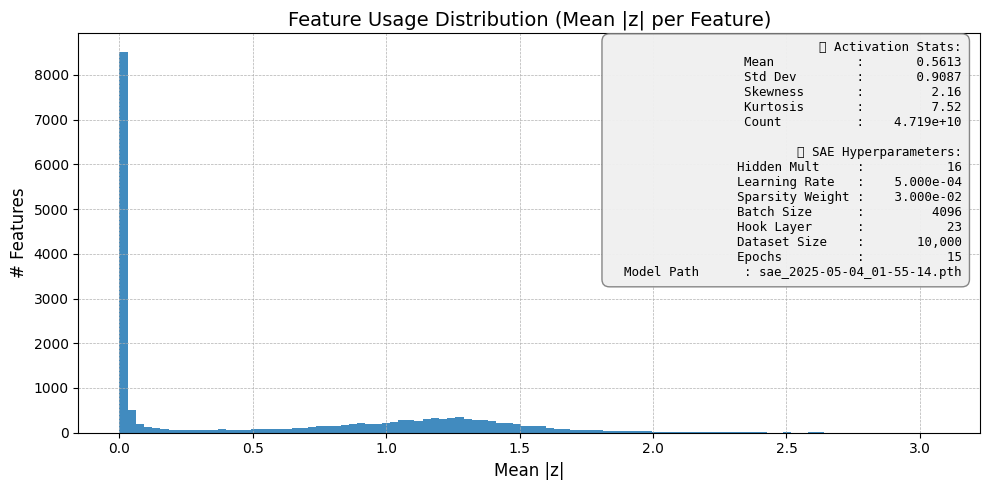

<Figure size 640x480 with 0 Axes>

In [27]:
# === Plot feature usage ===
plt.figure(figsize=(10, 5))
plt.hist(feature_usage.cpu().numpy(), bins=100, alpha=0.85)
plt.title("Feature Usage Distribution (Mean |z| per Feature)", fontsize=14)
plt.xlabel("Mean |z|", fontsize=12)
plt.ylabel("# Features", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)

# === Create aligned text block with scientific notation where needed ===
stats_text = (
    "📊 Activation Stats:\n"
    f"  Mean           : {mean_val:>12.4f}\n"
    f"  Std Dev        : {std_val:>12.4f}\n"
    f"  Skewness       : {skewness:>12.2f}\n"
    f"  Kurtosis       : {kurt:>12.2f}\n"
    f"  Count          : {global_count:>12.3e}"
)

hyperparams_text = (
    "🧮 SAE Hyperparameters:\n"
    f"  Hidden Mult     : {hidden_multiplier:>12}\n"
    f"  Learning Rate   : {learning_rate:>12.3e}\n"
    f"  Sparsity Weight : {sparsity_weight:>12.3e}\n"
    f"  Batch Size      : {batch_size:>12}\n"
    f"  Hook Layer      : {LAYER_INDEX:>12}\n"
    f"  Dataset Size    : {TRAINING_DATASET_SIZE:>12,d}\n"
    f"  Epochs          : {n_epochs:>12}\n"
    f"  Model Path      : {model_path.split('/')[-1]}"
)

full_text = f"{stats_text}\n\n{hyperparams_text}"

# === Add nicely formatted box inside the plot ===
props = dict(boxstyle="round,pad=0.6", facecolor="#f0f0f0", edgecolor="gray", alpha=0.95)
plt.gca().text(
    0.98, 0.98, full_text,
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
    family="monospace"
)

# === Finalize + show ===
plt.tight_layout()
plt.show()

# === Log to wandb ===
wandb.log({
    "feature_usage_histogram": wandb.Image(plt),
    "z_mean": mean_val,
    "z_std": std_val,
    "z_skewness": skewness,
    "z_kurtosis": kurt,
})
